# 特徴量の説明

# **各変数の説明**
SalePrice = 売価(目的変数)

MSSubClass = 建物の階級：年代,何階建てか等  
MSZoning = ゾーニング(建物の利用目的)  
LotFrontage = 道に接する長さ(?)  
LotArea = 敷地面積(feet^2)  
Street = 道へのアクセス(舗装or砂利)  
Alley = 路地へのアクセス(舗装or砂利orなし)  
LotShape = 建物の形状  
LandContour = 建物の立地(flatness)  
Utilities = ガス/水道/電気のうち使えるもの  
LotConfig = 土地構成(端っこ、とか内側とか行き止まりとか)  
LandSlope = 土地勾配  
  
要る？  
EnclosedPorch: 屋内のポーチ面積(feet^2)  
3SsnPorch: Three season porch area in square feet  
ScreenPorch: Screen porch area in square feet  
PoolArea = プール面積  
PoolQC = プールの質(そもそもあるなしでも良さそう)  
Fence = フェンスの質(防犯)  
MiscFeature = その他の特徴(不要？)  
  
MoSold: Month Sold  
YrSold: Year Sold  
SaleType: Type of sale  
SaleCondition: Condition of sale  

# ライブラリインポート

In [1]:
import math

# numpy , pandas
import numpy as np 
import pandas as pd

# scipy
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm,boxcox_normmax
from scipy.spatial import distance
from scipy.special import boxcox1p

# scikit-learn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LassoCV, LassoLarsIC, LassoLarsCV, RidgeCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

# 可視化用ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

#expand visualizing DataFrame
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)



# データセット読み込み
この際，Idは必要のない変数なので真っ先に削除．また，訓練データとテストデータの結合も行う．基本的に行を削除する作業以外の前処理は結合をしてから行うのがラク．

In [2]:
# 読み込み、Idの削除
train_and_Id = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test_and_Id = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train = train_and_Id.copy()
test = test_and_Id.copy()
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# trainについて、xとyに分割
train_x = train.drop("SalePrice", axis=1)
train_y = train['SalePrice']

# trainとtestを結合
all_df = pd.concat([train_x,test], axis=0)

In [3]:
# データの確認
print(train.shape)
print(test.shape)
print(all_df.shape)

(1460, 80)
(1459, 79)
(2919, 79)


# 変数のdtypes確認

In [4]:
all_df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object
HeatingQC         object


# 変数の文字列変換
数字が入っているが，数字の大小関係が予測に影響を与えない方が良いものはカテゴリ変数にすべき

In [5]:
num_to_str_list = ['MSSubClass', 'YrSold', 'MoSold']
for column in num_to_str_list:
    all_df[column] = train[column].astype(str)

In [6]:
# 再度dtypes確認
all_df.dtypes

MSSubClass        object
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object
HeatingQC         object


# 欠損値処理
今回は，文字列の変数の欠損は「'None'」，数字の文字列の変換は「0」で埋めるものとする

In [7]:
all_df.isnull().sum()[all_df.isnull().sum()>0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageArea         1
GarageCars         1
Electrical         1
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

In [8]:
# 欠損に意味のない特徴量は削除
all_df.drop('GarageYrBlt', axis=1, inplace=True)

# 意味のある欠損値を埋める
for column in all_df.columns:
    # dtypeがobjectの場合，文字列の変数なのでNoneに変換
    if all_df[column].dtype == 'O':
        all_df[column] = all_df[column].fillna("None")
    # dtypeがint, floatの場合，数字の変数なので0に変換
    else :
        all_df[column] = all_df[column].fillna(0)

In [9]:
all_df.isnull().sum()[all_df.isnull().sum()>0].sort_values(ascending=False)

Series([], dtype: int64)

# 特徴量エンジニアリング

In [10]:
all_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal


In [11]:
# ここで特徴量エンジニアリング、および不要な特徴量を削除

#物件の広さを合計した変数を作成
all_df["TotalSF"] = all_df["1stFlrSF"] + all_df["2ndFlrSF"] + all_df["TotalBsmtSF"]

# 何年後にremodされたか
all_df['YearRemod'] = all_df['YearRemodAdd'] - all_df['YearBuilt']

# 風呂の数
all_df['TotalBath'] = all_df['BsmtFullBath'] + 0.5 * all_df['BsmtHalfBath'] + all_df['FullBath'] + 0.5 * all_df['HalfBath']

all_df["Total_porch_SF"] = (all_df["OpenPorchSF"] + all_df["3SsnPorch"] + all_df["EnclosedPorch"] + all_df["ScreenPorch"] + 
                           all_df["WoodDeckSF"])

# 特徴量をもっているか否かに単純化
all_df["haspool"] = all_df["PoolArea"].apply(lambda x: 1 if x > 0 else 0)
all_df["has2ndfloor"] = all_df["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
all_df["hasgarage"] = all_df["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
all_df["hasbsmt"] = all_df["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
all_df["hasfireplace"] = all_df["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)

all_df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,YearRemod,TotalBath,Total_porch_SF,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,2566.0,0,3.5,61,0,1,1,1,0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,2524.0,0,2.5,298,0,0,1,1,1
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,2706.0,1,3.5,42,0,1,1,1,1
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,2473.0,55,2.0,307,0,1,1,1,1
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,3343.0,0,3.5,276,0,1,1,1,1
5,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732.0,Unf,0.0,64.0,796.0,GasA,Ex,Y,SBrkr,796,566,0,1362,1.0,0.0,1,1,1,1,TA,5,Typ,0,None,Attchd,Unf,2.0,480.0,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,2158.0,2,2.5,390,0,1,1,1,0
6,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369.0,Unf,0.0,317.0,1686.0,GasA,Ex,Y,SBrkr,1694,0,0,1694,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,RFn,2.0,636.0,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,3380.0,1,3.0,312,0,0,1,1,1
7,60,RL,0.0,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,3197.0,0,3.5,667,0,1,1,1,1
8,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,GasA,Gd,Y,FuseF,

In [12]:
all_df.select_dtypes(include=float)

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageCars,GarageArea,TotalSF,TotalBath
0,65.0,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2.0,548.0,2566.0,3.5
1,80.0,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,2.0,460.0,2524.0,2.5
2,68.0,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2.0,608.0,2706.0,3.5
3,60.0,0.0,216.0,0.0,540.0,756.0,1.0,0.0,3.0,642.0,2473.0,2.0
4,84.0,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,3.0,836.0,3343.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...
1454,21.0,0.0,0.0,0.0,546.0,546.0,0.0,0.0,0.0,0.0,1638.0,1.5
1455,21.0,0.0,252.0,0.0,294.0,546.0,0.0,0.0,1.0,286.0,1638.0,1.5
1456,160.0,0.0,1224.0,0.0,0.0,1224.0,1.0,0.0,2.0,576.0,2448.0,2.0
1457,62.0,0.0,337.0,0.0,575.0,912.0,0.0,1.0,0.0,0.0,1882.0,1.5


In [13]:
#学習データとテストデータに再分割
train_x = all_df.iloc[:train_x.shape[0],:].reset_index(drop=True) # 基本的にtrain_xはフィッティング以外で使わない
test = all_df.iloc[train_x.shape[0]:,:].reset_index(drop=True)
train = pd.concat([train_x, train_y], axis=1)

#サイズを確認、ここでtrain_xとtestの列数が同じこと、trainの行数が1460、testの行数が1459で変わっていないことを確認
print("train_x: "+str(train_x.shape))
print("test: "+str(test.shape))
print("train: "+str(train.shape))

train_x: (1460, 87)
test: (1459, 87)
train: (1460, 88)


In [14]:
def plot_featureInfo(df, feature):
    copy_df = df[feature].copy()
    copy = copy_df.values
    
    print("歪度：" + str(copy_df.skew()))
    print("尖度：" + str(copy_df.kurt()))
    
    fig = plt.figure(figsize=(12, 10))

    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
    
    # ヒストグラム
    sns.histplot(copy, ax = ax1)
    ax1.set_title(feature + "_HIST")
    
    # QQプロット
    stats.probplot(copy, plot = ax2)
    ax2.set_title(feature + "_QQPlot")
    
    # 箱ひげ図
    sns.boxplot(data = copy, orient = "v", ax = ax3)
    ax3.set_title(feature + "_BoxPlot")

In [15]:
# Yeo-Johnson変換
pt = PowerTransformer(method="yeo-johnson")
pt.fit(train_x[["TotalSF"]])

train[["TotalSF"]] = pt.transform(train[["TotalSF"]])
test[["TotalSF"]] = pt.transform(test[["TotalSF"]])

歪度：-0.06788500009511951
尖度：1.0676046890054645


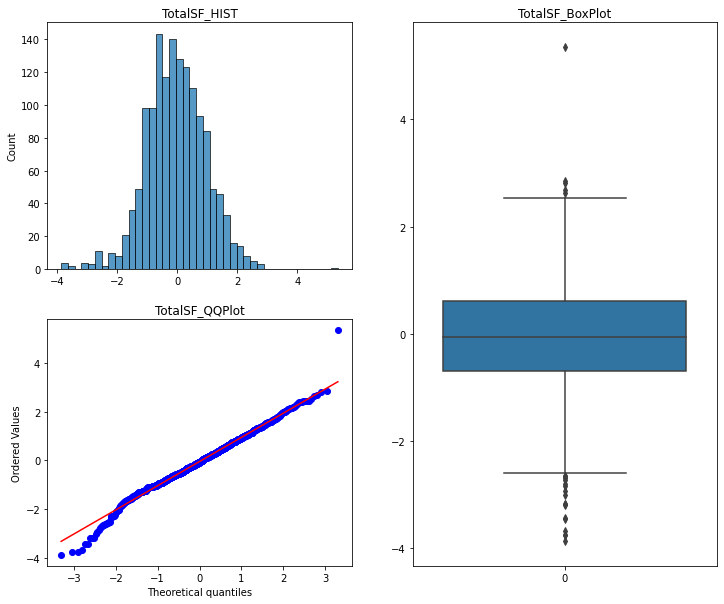

In [16]:
plot_featureInfo(test, "TotalSF")

In [17]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,YearRemod,TotalBath,Total_porch_SF,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,0.119006,0,3.5,61,0,1,1,1,0,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,0.065573,0,2.5,298,0,0,1,1,1,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,0.292337,1,3.5,42,0,1,1,1,1,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,-0.000249,55,2.0,307,0,1,1,1,1,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,1.002659,0,3.5,276,0,1,1,1,1,250000


# 目的変数の前処理
1. ヒストグラムの確認
2. 概要確認(歪度，尖度など)
3. 正規分布に近づくよう変換(今回は対数変換)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

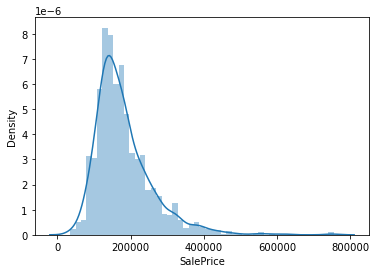

In [18]:
# SalePriceのヒストグラム
sns.distplot(train['SalePrice'])

In [19]:
# SalePriceの概要を見てみる
print(train["SalePrice"].describe())
print("歪度：{:4f}".format(train['SalePrice'].skew()))
print("尖度: {:4f}".format(train["SalePrice"].kurt()))

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
歪度：1.882876
尖度: 6.536282


count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePriceLog, dtype: float64
歪度: 0.1213
尖度: 0.8095


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


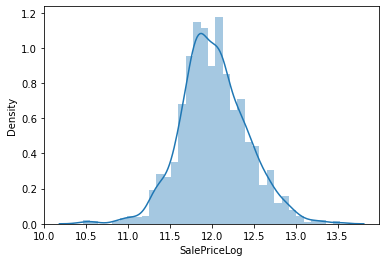

In [20]:
# SalePriceLogに対数変換した値を入れる．
train['SalePriceLog'] = np.log(train['SalePrice'])

sns.distplot(train['SalePriceLog'])
print(train["SalePriceLog"].describe())
print(f"歪度: {round(train['SalePriceLog'].skew(),4)}" )
print(f"尖度: {round(train['SalePriceLog'].kurt(),4)}" )

# ヒートマップの確認

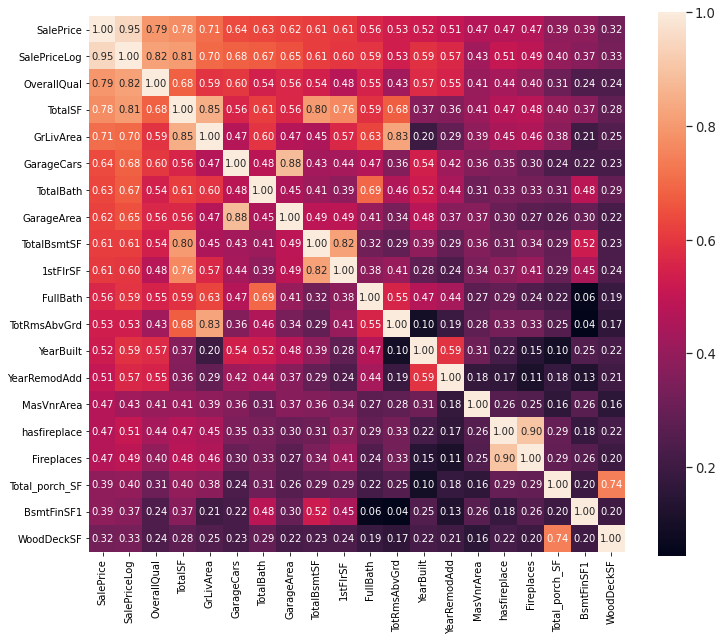

In [21]:
def heatmap(k, df, target_label):
    # 相関の高いものから順にk個
    # dfにはtrainのデータフレームを、target_labelには目的変数のラベル名を入れる("SalePrice"とか)
    corrmat = df.corr()
    cols = corrmat.nlargest(k, target_label)[target_label].index
    cm = np.corrcoef(df[cols].values.T)
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.set(font_scale=1.2)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

heatmap(20, train, 'SalePrice')

# 外れ値の除去

Text(0, 0.5, 'SalePrice')

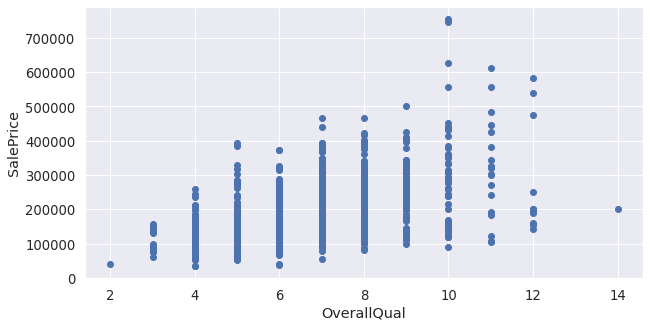

In [22]:
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 5))
plt.scatter(train["TotRmsAbvGrd"],train["SalePrice"])
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")

Text(0, 0.5, 'SalePrice')

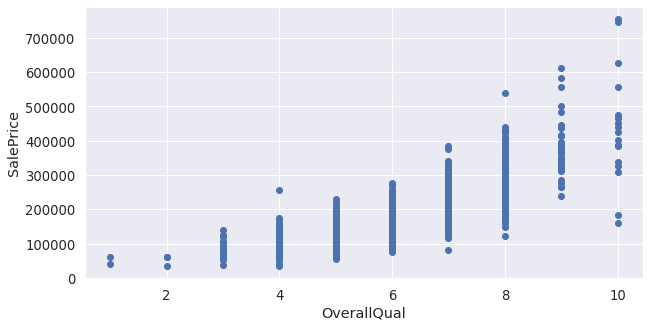

In [23]:
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 5))
plt.scatter(train["OverallQual"],train["SalePrice"])
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")

Text(0, 0.5, 'SalePrice')

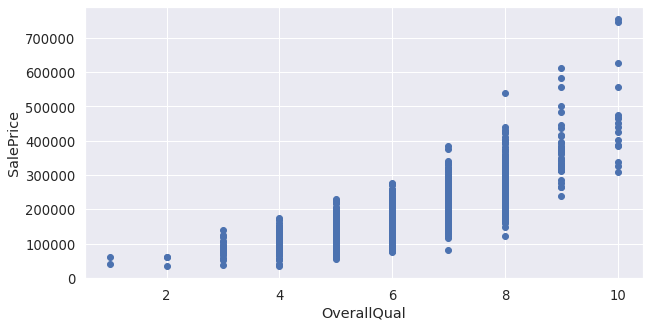

In [24]:
#外れ値を除外する
# train = train.drop(train[(train['OverallQual']==4) & (train['SalePrice']>200000)].index)
# train = train.drop(train[(train['OverallQual']==10) & (train['SalePrice']<200000)].index)

train = train[(train["OverallQual"] != 4) | (train["SalePrice"]<200000)]
train = train[(train["OverallQual"] != 10) | (train["SalePrice"]>200000)]

#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 5))
plt.scatter(train["OverallQual"],train["SalePrice"])
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")

Text(0, 0.5, 'SalePrice')

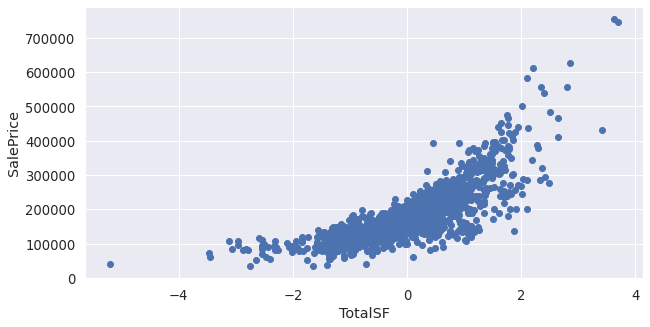

In [25]:
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 5))
plt.scatter(train["TotalSF"],train["SalePrice"])
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")

Text(0, 0.5, 'SalePrice')

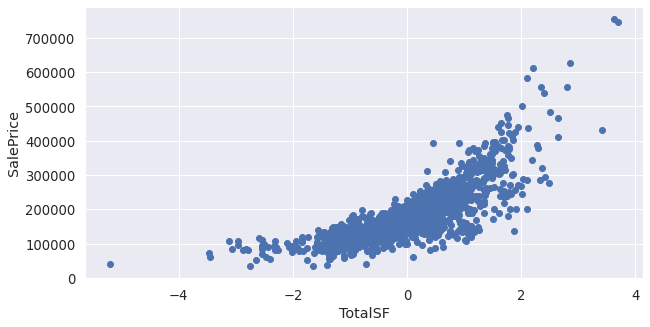

In [26]:
#外れ値を除外する
train = train.drop(train[(train['TotalSF']>7500) & (train['SalePrice']<300000)].index)

#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 5))
plt.scatter(train["TotalSF"],train["SalePrice"])
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")

Text(0, 0.5, 'SalePrice')

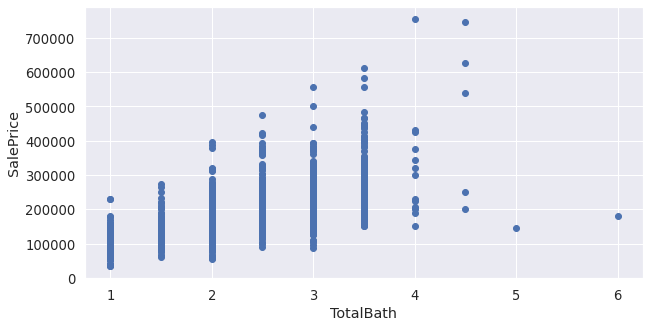

In [27]:
# 外れ値除去
# train = train.drop(train[(train['TotalBath']>5)].index)

#風呂の数と物件価格の散布図を作成
plt.figure(figsize=(10, 5))
plt.scatter(train["TotalBath"],train["SalePrice"])
plt.xlabel("TotalBath")
plt.ylabel("SalePrice")

# 学習データの説明変数と目的変数、予測データの説明変数にデータフレームを分割

In [28]:
train_y = train['SalePriceLog']
train_x = train.drop(["SalePrice", "SalePriceLog"], axis=1)

all_df = pd.concat([train_x, test], axis=0)

In [29]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,YearRemod,TotalBath,Total_porch_SF,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,SalePrice,SalePriceLog
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,0.119006,0,3.5,61,0,1,1,1,0,208500,12.247694
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,0.065573,0,2.5,298,0,0,1,1,1,181500,12.109011
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,0.292337,1,3.5,42,0,1,1,1,1,223500,12.317167
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,-0.000249,55,2.0,307,0,1,1,1,1,140000,11.849398
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,1.002659,0,3.5,276,0,1,1,1,1,250000,12.429216


In [30]:
test.shape

(1459, 87)

In [31]:
# OneHotEncoding
all_df = pd.get_dummies(all_df)

train_x = all_df.iloc[:train_x.shape[0], :]
test = all_df.iloc[train_x.shape[0]:, :]

In [32]:
test.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF,YearRemod,TotalBath,Total_porch_SF,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,...,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,-1.023855,0,1.0,260,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,0.233712,0,1.5,429,0,0,1,1,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,0.107614,1,2.5,246,0,1,1,1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,2.0,470.0,360,36,0,0,0,0,0,0.073248,0,2.5,396,0,1,1,1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,2.0,506.0,0,82,0,0,144,0,0,0.111414,0,2.0,226,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


# trainを分割する  
trainをまずは8対2で分割。それぞれval、trainvalとする  
trainvalについて交差検証をし、パラメータチューニング→最後にvalで汎化性能の確認という流れ

In [33]:
# 分割
trainval_x, val_x, trainval_y, val_y = train_test_split(train_x, train_y, train_size=0.8, 
                                                       random_state=0)
# 交差検証の分割方法定義
kfolds = KFold(n_splits=5, shuffle=True, random_state=0)

# 分割できているか確認
print(trainval_x.shape)
print(trainval_y.shape)
print(val_x.shape)
print(val_y.shape)

(1165, 346)
(1165,)
(292, 346)
(292,)


# モデル構築用に関数を色々つくる

In [34]:
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

def RMSE(y_true, y_pred):
    # RMSE (Root Mean Square Error: 平均二乗誤差平方根) を計算する関数
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def neg_RMSE(y_true, y_pred):
    # RMSE (Root Mean Square Error: 平均二乗誤差平方根) を計算する関数
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return -rmse




def cv_rmse(model, X, y):
    scoring = {"RMSE": make_scorer(RMSE)}
    scores = cross_validate(model, X, y, cv=kfolds, scoring=scoring, 
                            return_train_score=True, return_estimator=False)
    return scores

def model_validation(model, X, y):
    score = cv_rmse(model, X, y)
    print(score["train_RMSE"].mean())
    print(score["test_RMSE"].mean())
    print("-------------------------")

# Validation

In [35]:
# GBDTのパラメータチューニング(チューニングが終わったらこれはすべてコメントアウトしよう)

In [36]:
# いろんなモデル
# Ridge
ridge = Pipeline([("scaler", RobustScaler()),("ridge", RidgeCV(cv=kfolds))])

# Lasso
lasso = Pipeline([("scaler", RobustScaler()),("lasso", LassoCV(cv=kfolds))])

# ElasticNet
elastic = Pipeline([("scaler", RobustScaler()),("elastic", ElasticNetCV(cv=kfolds))])



In [37]:
# サポートベクターマシンのパラメータチューニング

# まずはパイプラインの生成
svr = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("svr", SVR(C=50, epsilon=0.01, gamma=0.0003))
    ]
)

# 独自の評価指標
# scoring = {"RMSE": make_scorer(neg_RMSE)}

# チューニングするパラメータの候補
# tuned_parameters = {"svr__C":[10, 20, 30, 40],
#                    "svr__gamma":[1e-03, 1e-04, 1e-05],
#                    "svr__epsilon":[1e-03, 1e-04, 1e-05]}

# グリッドサーチ
# svr_pipe = GridSearchCV(
#     svr_pipe, # 識別器
#     tuned_parameters, # 最適化したいパラメータセット 
#     cv=kfolds, # 交差検証の回数
#     scoring=scoring,# モデルの評価関数の指定
#     refit="RMSE"
# )

# 交差検証を用いたパラメータ調整
# cv_score = cv_rmse(svr, trainval_x, trainval_y)
# print(cv_score["train_RMSE"].mean())
# print(cv_score["test_RMSE"].mean())

In [38]:
# GBDTのパラメータチューニング
GBDT = GradientBoostingRegressor(max_depth=2, 
                                 n_estimators=200, 
                                 learning_rate=0.11,
                                 min_samples_leaf = 5,
                                 random_state=0)

# cv_score = cv_rmse(GBDT, trainval_x, trainval_y)
# print(cv_score["train_RMSE"].mean())
# print(cv_score["test_RMSE"].mean())

In [39]:
# xgboost
xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

# 交差検証によるパラメータ評価、する必要がない場合は時間がかかるのでコメントアウト
# cv_score = cv_rmse(xgboost, trainval_x, trainval_y)
# print(cv_score["train_RMSE"].mean())
# print(cv_score["test_RMSE"].mean())

In [40]:
# lightGBM
lightgbm = lgb.LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

# 交差検証によるパラメータ評価、する必要がない場合は時間がかかるのでコメントアウト
# cv_score = cv_rmse(lightgbm, trainval_x, trainval_y)
# print(cv_score["train_RMSE"].mean())
# print(cv_score["test_RMSE"].mean())

In [41]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elastic, svr, GBDT, lightgbm, xgboost),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [42]:
stack_gen.fit(np.array(trainval_x), np.array(trainval_y))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 w

StackingCVRegressor(meta_regressor=XGBRegressor(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=0.7, gamma=0,
                                                gpu_id=None,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=0.01,
                                                max_delta_step=None,
                                                max_depth=3, min_child_weight=0,
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estimators=3460, n_jobs=No...
                                             max_delta

In [43]:
# 他のモデルについてもfit
lasso.fit(trainval_x, trainval_y)
ridge.fit(trainval_x, trainval_y)
elastic.fit(trainval_x, trainval_y)
GBDT.fit(trainval_x, trainval_y)
lightgbm.fit(trainval_x, trainval_y)
xgboost.fit(trainval_x, trainval_y)

[05:36:57] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=3460, n_jobs=4, nthread=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=27, reg_alpha=6e-05,
             reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
# スタッキングの都合上予測値は全てndarrayに統一する

y_stackval = stack_gen.predict(np.array(val_x))
y_ridgeval = np.array(ridge.predict(val_x))
y_lassoval = np.array(lasso.predict(val_x))
y_elasticval = np.array(elastic.predict(val_x))
y_GBDTval = np.array(GBDT.predict(val_x))
y_lightval = np.array(lightgbm.predict(val_x))
y_xgbval = np.array(xgboost.predict(val_x))

In [45]:
print(RMSE(y_stackval, val_y))
print(RMSE(y_ridgeval, val_y))
print(RMSE(y_lassoval, val_y))
print(RMSE(y_elasticval, val_y))
print(RMSE(y_GBDTval, val_y))
print(RMSE(y_lightval, val_y))
print(RMSE(y_xgbval, val_y))

0.11107020449885646
0.1144984662183852
0.12852104257832314
0.12867081976948685
0.1168494774184876
0.11928109235025831
0.11003808182405476


In [46]:
y_blendval = 0.3 * y_stackval + 0.1 * y_ridgeval + 0.1 * y_lassoval + 0.1 * y_elasticval + 0.1 * y_GBDTval + 0.1 * y_lightval + 0.2 * y_xgbval 
RMSE(y_blendval, val_y)

0.10997046258940214

In [47]:
y_stacktest = stack_gen.predict(np.array(test))
y_ridgetest = np.array(ridge.predict(test))
y_lassotest = np.array(lasso.predict(test))
y_elastictest = np.array(elastic.predict(test))
y_GBDTtest = np.array(GBDT.predict(test))
y_lighttest = np.array(lightgbm.predict(test))
y_xgbtest = np.array(xgboost.predict(test))

y_blendtest = 0.3 * y_stacktest + 0.1 * y_ridgetest + 0.1 * y_lassotest + 0.1 * y_elastictest + 0.1 * y_GBDTtest + 0.1 * y_lighttest + 0.2 * y_xgbtest 

In [48]:
# 提出用データフレームの作成
y_blendtest = pd.DataFrame(np.exp(y_blendtest), columns=["SalePrice"])
test_Id = test_and_Id['Id']
submission = pd.concat([test_Id, y_blendtest], axis=1)
submission.head()

,Id,SalePrice
0,1461,122088.421346
1,1462,162814.316821
2,1463,183244.013421
3,1464,202314.131070
4,1465,188719.913704


In [49]:
# csvに変換
submission.to_csv("./submission_0320.csv", index=False)